In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as SNS
import plotly.graph_objs as go
%matplotlib inline

In [33]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import itertools
from prophet.diagnostics import performance_metrics, cross_validation
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [22]:
daily = pd.read_csv('prophetdf.csv')
daily.head()

,ds,y
0,2019-06-01,4087.236534
1,2019-06-02,65.848327
2,2019-06-03,1364.979529
3,2019-06-04,68385.521621
4,2019-06-05,65135.657001


In [36]:
#create train and test sets for one month period
train = daily[:-30]
test = daily[-30:]

22:33:40 - cmdstanpy - INFO - Chain [1] start processing
22:33:41 - cmdstanpy - INFO - Chain [1] done processing


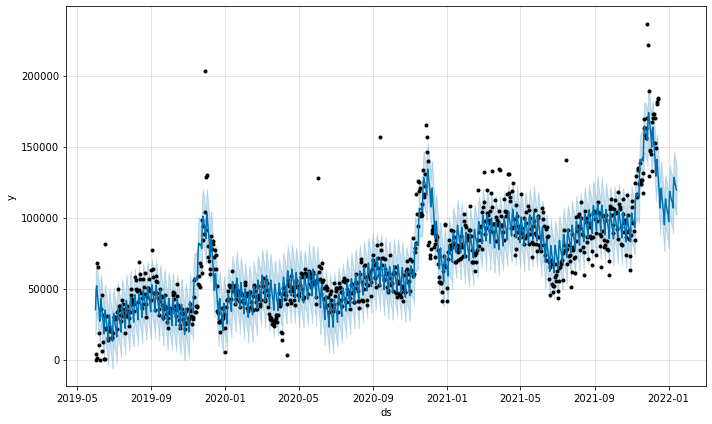

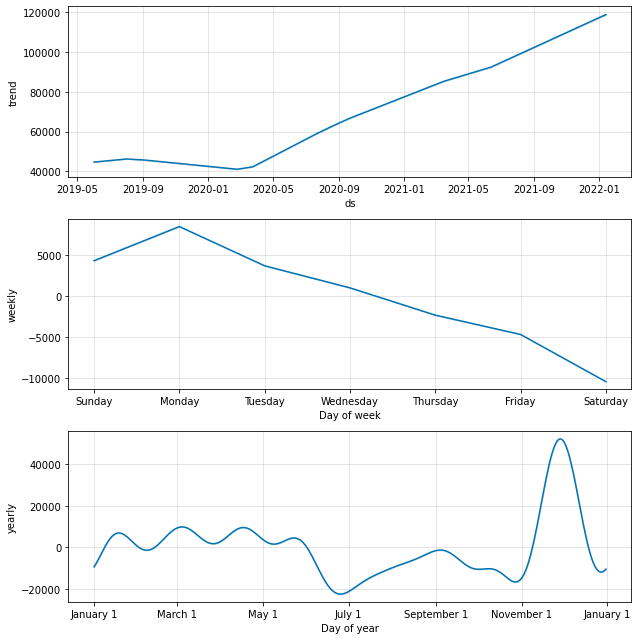

In [37]:
#baseline model

m = Prophet()
m.fit(train)
future = pd.DataFrame()
future['ds'] = daily['ds']
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [38]:
y_pred = forecast['yhat'][-30:]
y_test = test['y']
np.sqrt(mean_squared_error(y_test, y_pred))

31376.50024214348

In [40]:
#mean_absolute_percentage_error(y_test, y_pred) 

1.5028797126161464

In [199]:
#create holiday for new years eve
nye = pd.DataFrame({
  'holiday': 'nye',
  'ds': pd.to_datetime(['2019-12-31', '2020-12-31','2021-12-31']),
  'lower_window': 0,
  'upper_window': 0,
})
black_friday = pd.DataFrame({
  'holiday': 'black_friday',
  'ds': pd.to_datetime(['2019-11-29', '2020-11-27','2021-11-26']),
  'lower_window': 0,
  'upper_window': 3,
})
#create holiday for initial covid lockdown
covid_lockdown = pd.DataFrame({
  'holiday': 'covid_lockdown',
  'ds': pd.date_range('2020-03-12','2020-04-13'), # march 12 state of emergency declared, april 14 borders reopenned
  'lower_window': 0,
  'upper_window': 0,
})


'''covid_restrictions = pd.DataFrame({
  'holiday': 'covid_lockdown',
  'ds': pd.date_range('2020-10-22','2020-12-02'),
  'lower_window': 0,
  'upper_window': 0,
})
covid_restrictions2 = pd.DataFrame({
  'holiday': 'covid_lockdown',
  'ds': pd.date_range('2021-01-23','2021-04-11'),
  'lower_window': 0,
  'upper_window': 0,
})'''
#combine holiday dataframes
holidays = pd.concat((nye, covid_lockdown, black_friday)) #covid_restrictions, covid_restrictions2

In [200]:
#remove outliers
daily_cl = daily.drop(index=[366,468,774,314,957]) #180, 213
daily_cl = daily_cl[30:]
daily_cl['ds']=  pd.to_datetime(daily_cl['ds'])
daily_cl = daily_cl.reset_index(drop=True)
train_cl = daily_cl[:-30]
test_cl = daily_cl[-30:]

00:19:11 - cmdstanpy - INFO - Chain [1] start processing
00:19:11 - cmdstanpy - INFO - Chain [1] done processing


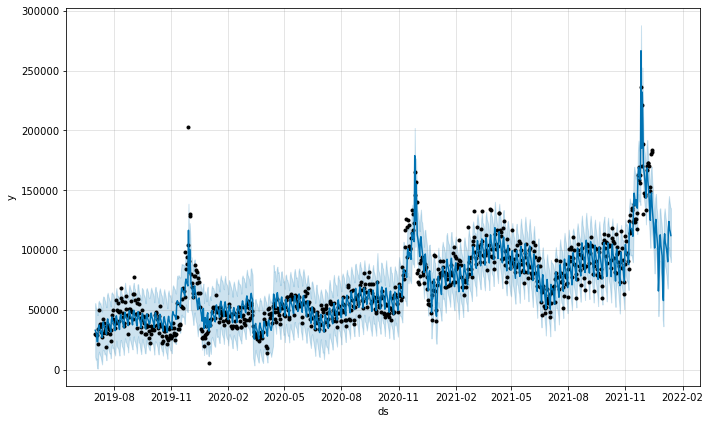

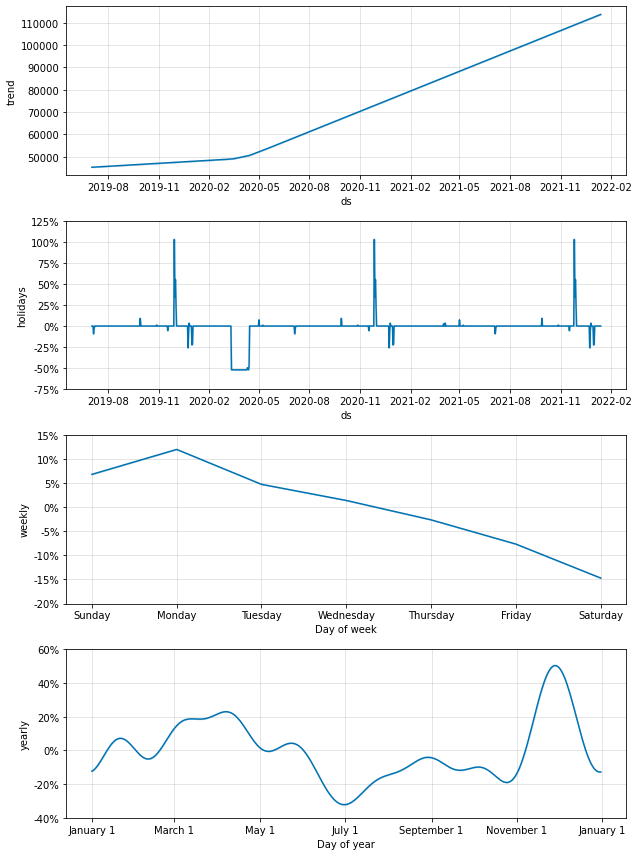

In [201]:
#prophet model with holidays and gridsearched parameters
m = Prophet(holidays = holidays, interval_width=0.95, changepoint_prior_scale=.01, holidays_prior_scale = 0.75, seasonality_prior_scale=0.05, seasonality_mode = "multiplicative") 
#{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.025, 'holidays_prior_scale': 0.75}
m.add_country_holidays(country_name='CZ')
#m.add_regressor('stringency_index')
m.fit(train_cl)
future = pd.DataFrame()
future['ds'] = daily_cl['ds']
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

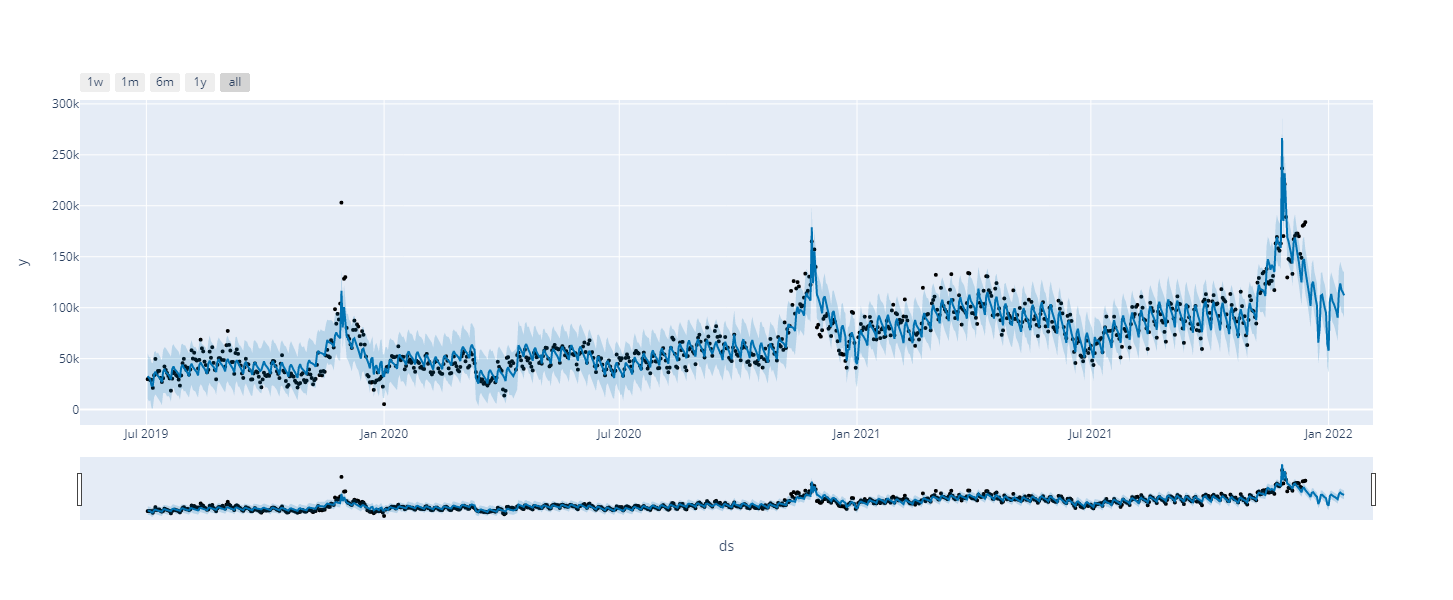

In [202]:
plot_plotly(m, forecast)


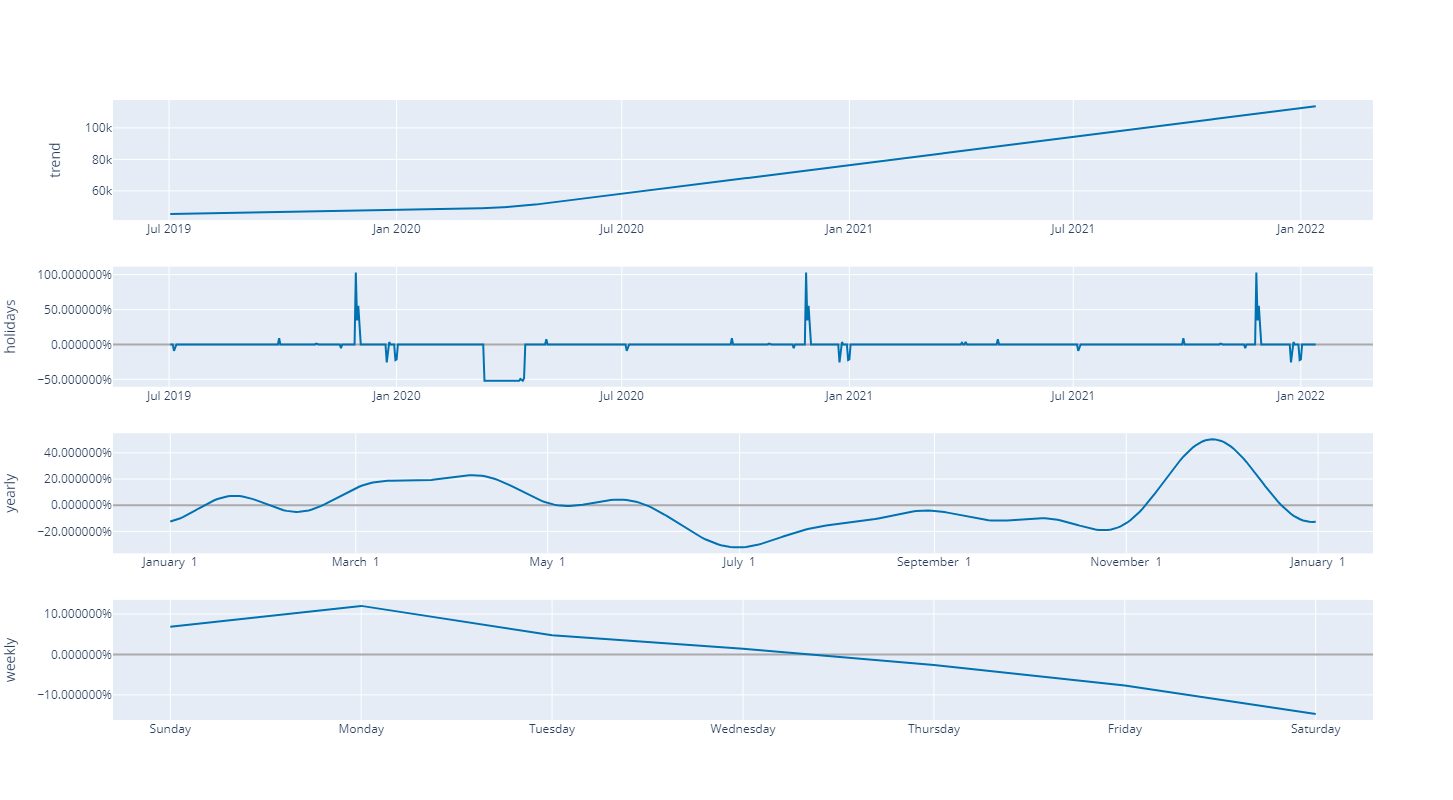

In [203]:
plot_components_plotly(m, forecast)

In [204]:
y_pred = forecast['yhat'][-30:]
y_test = test_cl['y']
np.sqrt(mean_squared_error(y_test, y_pred))

18185.801394254668

In [162]:
mean_absolute_percentage_error(y_test, y_pred)

0.1528983940380685

In [35]:
# parameter grid for grid search
param_grid = {
    'changepoint_prior_scale': [0.0075, 0.01, 0.025],
    'seasonality_prior_scale': [0.025, 0.05, 0.075, 0.1, 0.5,],
    'holidays_prior_scale': [0.25, 0.5, 0.75, 1],
    #'seasonality_mode': ['additive', 'multiplicative']
}
#'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive'}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# Use cross validation to evaluate all parameters
rmses = [] 
for params in all_params:
    m = Prophet(**params, holidays=holidays, seasonality_mode ='multiplicative')
    m.add_country_holidays(country_name='CZ')
    m.fit(daily_cl)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
best_params = all_params[np.argmin(rmses)]
print(best_params)

02:34:40 - cmdstanpy - INFO - Chain [1] start processing
02:34:40 - cmdstanpy - INFO - Chain [1] done processing
02:34:58 - cmdstanpy - INFO - Chain [1] start processing
02:34:58 - cmdstanpy - INFO - Chain [1] done processing
02:35:15 - cmdstanpy - INFO - Chain [1] start processing
02:35:15 - cmdstanpy - INFO - Chain [1] done processing
02:35:34 - cmdstanpy - INFO - Chain [1] start processing
02:35:34 - cmdstanpy - INFO - Chain [1] done processing
02:35:53 - cmdstanpy - INFO - Chain [1] start processing
02:35:53 - cmdstanpy - INFO - Chain [1] done processing
02:36:10 - cmdstanpy - INFO - Chain [1] start processing
02:36:10 - cmdstanpy - INFO - Chain [1] done processing
02:36:28 - cmdstanpy - INFO - Chain [1] start processing
02:36:28 - cmdstanpy - INFO - Chain [1] done processing
02:36:43 - cmdstanpy - INFO - Chain [1] start processing
02:36:43 - cmdstanpy - INFO - Chain [1] done processing
02:36:58 - cmdstanpy - INFO - Chain [1] start processing
02:36:58 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.025, 'holidays_prior_scale': 0.75}


In [205]:
weather = pd.read_csv('weather.csv')


In [206]:
weather['ds']=  pd.to_datetime(weather['ds'])
daily_w = pd.merge(daily_cl,weather,on='ds',how='left')

In [165]:
daily_w.head()

,ds,y,temperature,condition,humidity,condition_severity
0,2019-07-02,29825.892188,21.1,Partly cloudy,63.0,0
1,2019-07-03,30148.139918,18.8,Sunny,51.0,0
2,2019-07-04,28886.698448,20.4,Sunny,54.0,0
3,2019-07-05,29277.998737,22.0,Partly cloudy,51.0,0
4,2019-07-06,21320.833411,25.0,Sunny,56.0,0


In [166]:
train_w = daily_w[:-30]
test_w = daily_w[-30:]

00:41:20 - cmdstanpy - INFO - Chain [1] start processing
00:41:20 - cmdstanpy - INFO - Chain [1] done processing


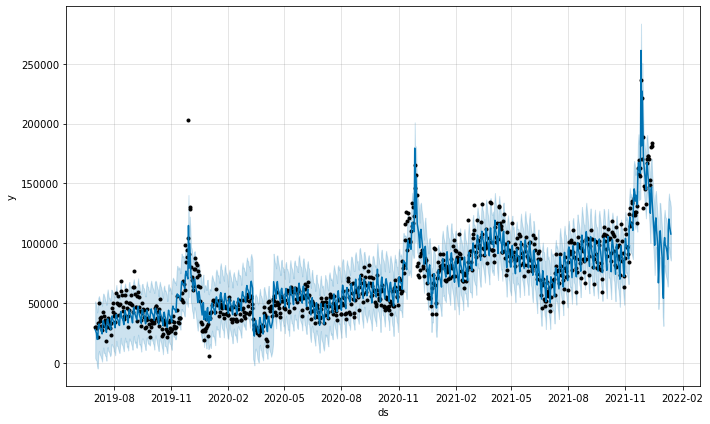

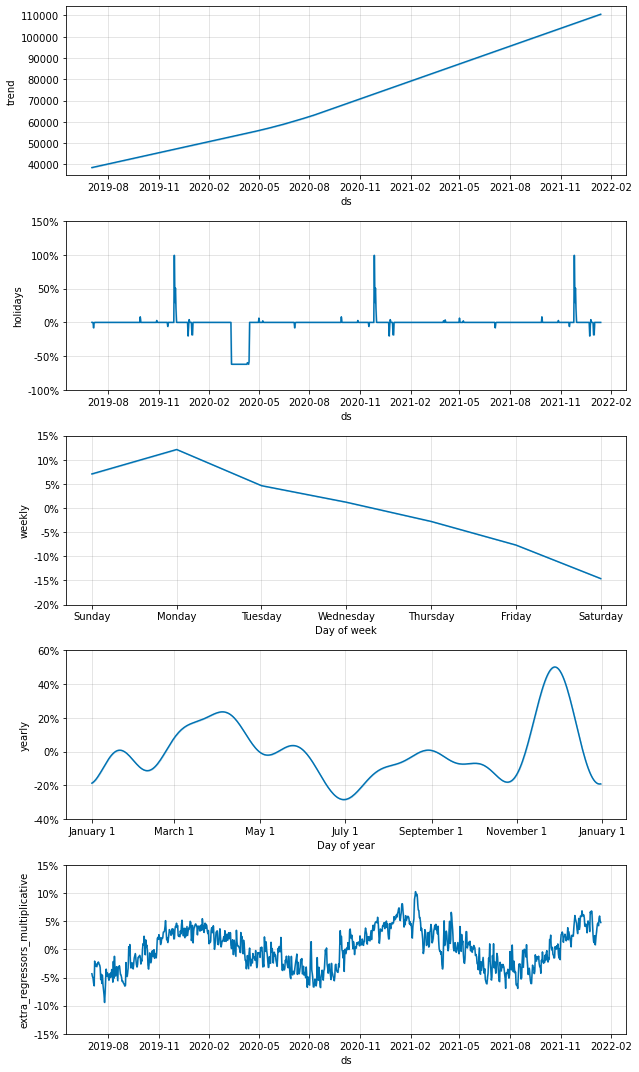

In [226]:
#prophet model with holidays and weather
m = Prophet(holidays = holidays, interval_width=0.95, changepoint_prior_scale=0.005, holidays_prior_scale = 0.50, seasonality_prior_scale=0.05, seasonality_mode = "multiplicative") 
#{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive'}
#{'changepoint_prior_scale': 0.0075, 'seasonality_prior_scale': 0.025, 'holidays_prior_scale': 0.25}
m.add_country_holidays(country_name='CZ')
m.add_regressor('temperature')
#m.add_regressor('condition_severity')
m.add_regressor('humidity')
m.fit(train_w)
future = pd.DataFrame()
future['ds'] = daily_w['ds']
future['temperature'] = daily_w['temperature']
#future['condition_severity'] = daily_w['condition_severity']
future['humidity'] = daily_w['humidity']
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

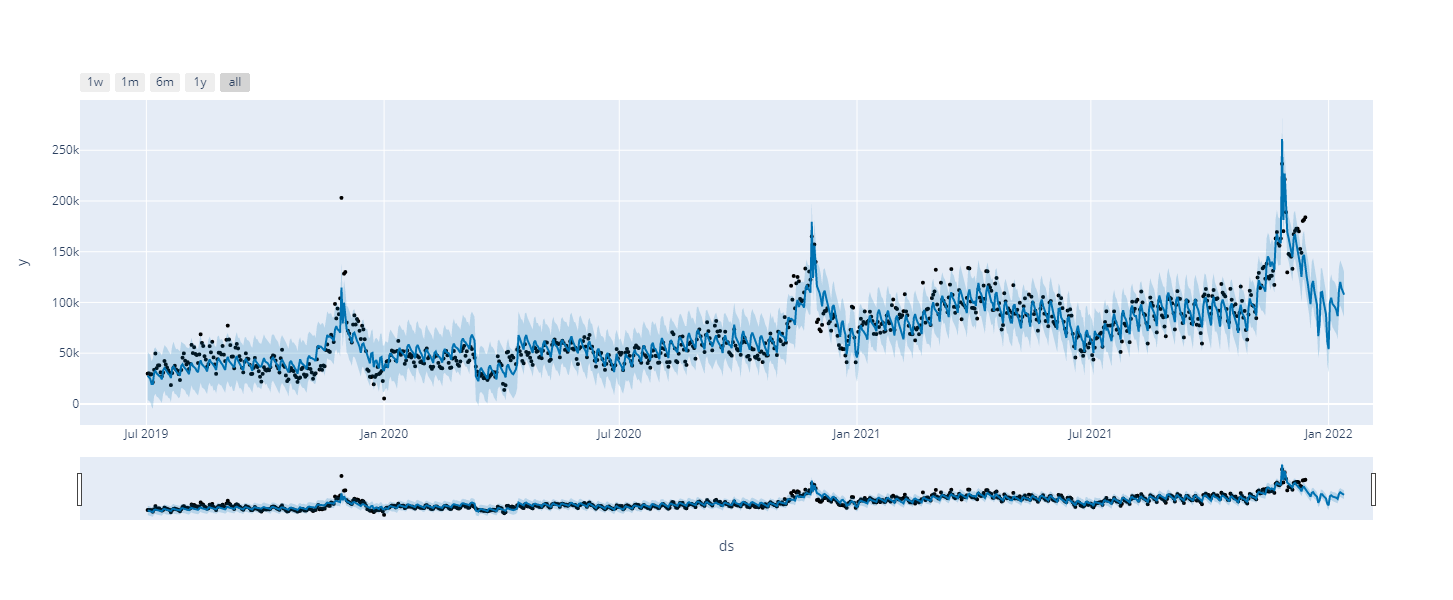

In [227]:
plot_plotly(m, forecast)


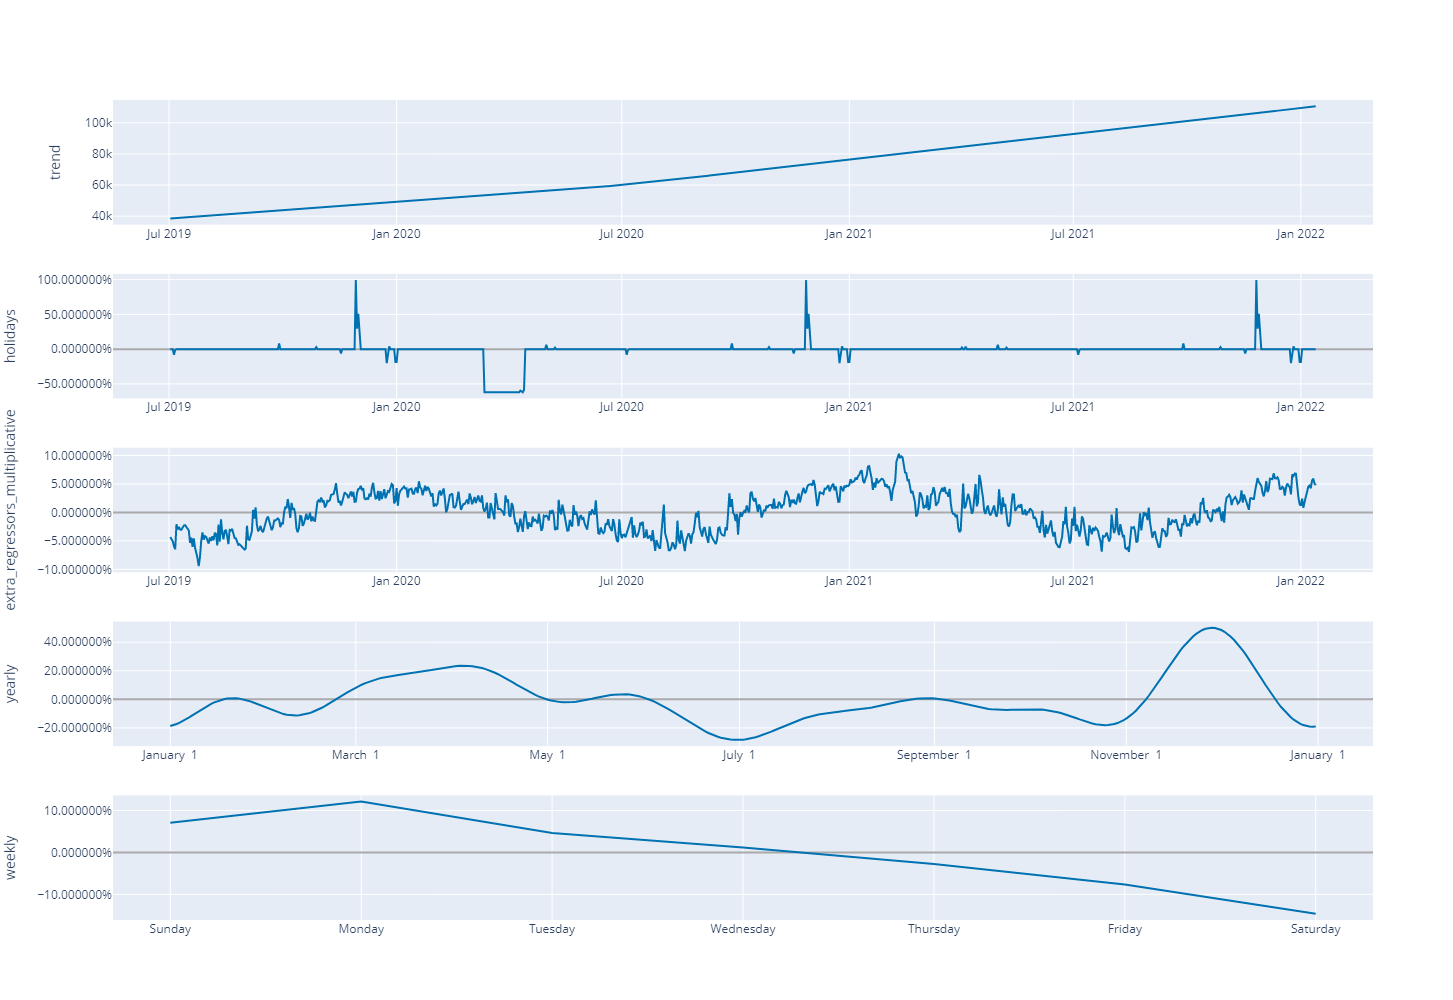

In [228]:
plot_components_plotly(m, forecast)

In [229]:
y_pred = forecast['yhat'][-30:]
y_test = test_w['y']
np.sqrt(mean_squared_error(y_test, y_pred))

16808.23325801389

In [230]:
forecast.to_csv('prophet_forecast.csv')

In [212]:
# parameter grid for grid search
param_grid = {
    'changepoint_prior_scale': [0.0075, 0.01, 0.025],
    'seasonality_prior_scale': [0.025, 0.05, 0.075, 0.1, 0.5,],
    'holidays_prior_scale': [0.25, 0.5, 0.75, 1],
   # 'seasonality_mode': ['additive', 'multiplicative']
}
#'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive'}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# Use cross validation to evaluate all parameters
rmses = [] 
for params in all_params:
    m = Prophet(**params, holidays=holidays, seasonality_mode = "multiplicative")
    m.add_country_holidays(country_name='CZ')
    m.add_regressor('temperature')
    m.add_regressor('humidity')
    m.fit(daily_w)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
best_params = all_params[np.argmin(rmses)]
print(best_params)

00:20:57 - cmdstanpy - INFO - Chain [1] start processing
00:20:57 - cmdstanpy - INFO - Chain [1] done processing
00:21:13 - cmdstanpy - INFO - Chain [1] start processing
00:21:13 - cmdstanpy - INFO - Chain [1] done processing
00:21:29 - cmdstanpy - INFO - Chain [1] start processing
00:21:29 - cmdstanpy - INFO - Chain [1] done processing
00:21:44 - cmdstanpy - INFO - Chain [1] start processing
00:21:45 - cmdstanpy - INFO - Chain [1] done processing
00:22:00 - cmdstanpy - INFO - Chain [1] start processing
00:22:01 - cmdstanpy - INFO - Chain [1] done processing
00:22:17 - cmdstanpy - INFO - Chain [1] start processing
00:22:17 - cmdstanpy - INFO - Chain [1] done processing
00:22:33 - cmdstanpy - INFO - Chain [1] start processing
00:22:33 - cmdstanpy - INFO - Chain [1] done processing
00:22:49 - cmdstanpy - INFO - Chain [1] start processing
00:22:49 - cmdstanpy - INFO - Chain [1] done processing
00:23:06 - cmdstanpy - INFO - Chain [1] start processing
00:23:06 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 0.0075, 'seasonality_prior_scale': 0.025, 'holidays_prior_scale': 0.25}
